In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import random
from random import sample

from typing import List

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

%matplotlib inline

In [2]:
data = pd.read_csv('./data/orphos.txt', sep=';')
data.head()

,CORRECT,MISTAKE,WEIGHT
0,болото,болотл,0.3333
1,болото,болотао,0.2500
2,болото,балото,0.1219
3,болото,болто,0.0562
4,болото,болотаъ,0.0526


In [3]:
correct_df = data[['CORRECT']].copy()
mistake_df = data[['MISTAKE']].copy().sample(frac=0.1).reset_index(drop=True) # only 10%

correct_df['is_error'] = 0
mistake_df['is_error'] = 1

correct_df.rename({'CORRECT': 'word'}, axis=1, inplace=True)
mistake_df.rename({'MISTAKE': 'word'}, axis=1, inplace=True)

df = pd.concat([correct_df, mistake_df], axis=0, ignore_index=True)

In [4]:
df = df.sample(frac=1).reset_index(drop=True) # random shuffle

In [5]:
generated_dataset = df['word'].tolist()

lines = [' '.join(list(line)) for line in generated_dataset]

lines[:3]

['м з д а', 'б е з д е н е ж ь е', 'з д а ч а']

In [6]:
tokens = []
for text in lines:
    tokens.extend(text)
tokens = list(set(tokens))

In [7]:
from sklearn.model_selection import train_test_split
train_lines, val_lines, y_train, y_val = train_test_split(lines, df['is_error'],  test_size=0.25, random_state=seed)

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('count', CountVectorizer(vocabulary=tokens, tokenizer=lambda x: x.split(' '), token_pattern=None)),
                  ('tfidf', TfidfTransformer())]).fit(train_lines)

In [9]:
len(tokens)

35

# RSRAE

In [15]:
class RSRAutoEncoder(nn.Module):
    def __init__(self, input_dim, d, D):
        super().__init__()
        self.encoder = nn.Sequential(
          nn.Linear(input_dim, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim // 4),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 4, D)
        )

        self.rsr = RSRLayer(d, D)

        self.decoder = nn.Sequential(
          nn.Linear(d, D),
          nn.LeakyReLU(),
          nn.Linear(D, input_dim // 2),
          nn.LeakyReLU(),
          nn.Linear(input_dim // 2, input_dim)
        )
    
    def forward(self, x):
        enc = self.encoder(x) # obtain the embedding from the encoder
        latent = self.rsr(enc) # RSR manifold
        dec = self.decoder(latent) # obtain the representation in the input space
        return enc, dec, latent, self.rsr.A

In [16]:
class RSRLayer(nn.Module):
    def __init__(self, d: int, D: int):
        super().__init__()
        self.d = d
        self.D = D
        self.A = nn.Parameter(torch.nn.init.orthogonal_(torch.empty(d, D)))

    def forward(self, z):
        z_hat = self.A @ z.view(z.size(0), self.D, 1)
        return z_hat.squeeze(2)

In [17]:
class RSRLoss(nn.Module):
    def __init__(self, lambda1, lambda2, d, D):
        super().__init__()
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.d = d
        self.D = D
        self.register_buffer(
            "Id", torch.eye(d)
        )

    def forward(self, z, A):
        z_hat = A @ z.view(z.size(0), self.D, 1)
        AtAz = (A.T @ z_hat).squeeze(2)
        term1 = torch.sum(
            torch.norm(z - AtAz, p=2)
        )

        term2 = torch.norm(
            A @ A.T - self.Id, p=2
        ) ** 2

        return self.lambda1 * term1 + self.lambda2 * term2

In [18]:
class L2p_Loss(nn.Module):
    def __init__(self, p=1.0):
        super().__init__()
        self.p = p
  
    def forward(self, y_hat, y):
        return torch.sum(
            torch.pow(
                torch.norm(y - y_hat, p=2), self.p
            )
        )

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [94]:
batch_size = 128
score_val_every = 1000

input_dim = 35
d = 8
D = 16

model = RSRAutoEncoder(input_dim, d, D)

reconctruction_loss = L2p_Loss().to(device)
rsr_loss = RSRLoss(1, 1, d, D).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4)

model.to(device)

RSRAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=35, out_features=17, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=17, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8, out_features=16, bias=True)
  )
  (rsr): RSRLayer()
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=16, out_features=17, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=17, out_features=35, bias=True)
  )
)

In [95]:
class TypoDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        return torch.as_tensor(self.data[i]).to(torch.float32).to(device)

In [96]:
tfidf_train = pipe.transform(train_lines).toarray()
tfidf_val = pipe.transform(val_lines).toarray()

train_dataset = TypoDataset(tfidf_train)
val_dataset = TypoDataset(tfidf_val)

In [97]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [98]:
def score_val(model, dataloader):
    loss = 0
    batches = 0
    for batch in dataloader:
        batches += 1
        
        enc, dec, latent, A = model(batch)
        rec_loss_i = reconctruction_loss(torch.sigmoid(dec), batch)
        rsr_loss_i = rsr_loss(enc, A)

        loss += rec_loss_i + rsr_loss_i

    return loss / batches

In [99]:
score_val(model, val_dataloader)

tensor(27.2158, device='cuda:0', grad_fn=<DivBackward0>)

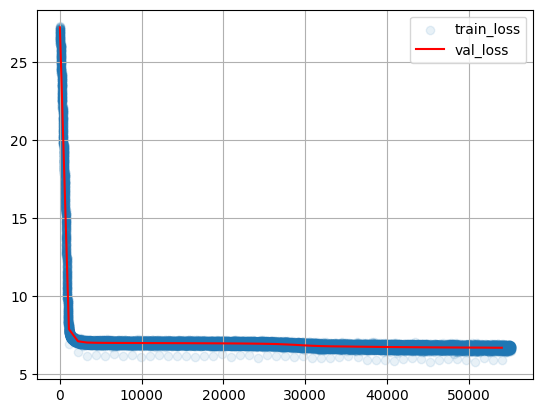

In [100]:
from IPython.display import clear_output

train_history, val_history = [], []

for epoch in range(50):
    model.eval()
    val_history.append((len(train_dataloader)*epoch, score_val(model, val_dataloader).item()))
    model.train()
    for i, batch in enumerate(train_dataloader):
        enc, dec, latent, A = model(batch)
    
        rec_loss_i = reconctruction_loss(torch.sigmoid(dec), batch)
        rsr_loss_i = rsr_loss(enc, A)
        
        loss_i = rec_loss_i + rsr_loss_i
        
        opt.zero_grad()
        loss_i.backward()
        opt.step()
            
        train_history.append((len(train_dataloader)*epoch+i, loss_i.item()))
        
        if (i + 1) % 50 == 0:
            clear_output(True)
            plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
            if len(val_history):
                plt.plot(*zip(*val_history), color='red', label='val_loss')
            plt.legend(); plt.grid(); plt.show()
        
        # if (i + 1) % score_val_every == 0:
        #     print("Scoring val...")
        #     val_history.append((i, score_lines(model, val_lines, batch_size)))
        #     print('#%i Val loss: %.3f' % val_history[-1])

tensor([[ 1.6352e-03,  1.2317e-01,  7.9851e-02,  1.5550e-02,  1.7416e-01,
         -2.1251e-04,  3.2071e-02,  6.3848e-02, -5.6177e-06,  1.2635e-02,
          6.0250e-02,  9.6397e-02,  2.5088e-02,  5.8560e-02,  9.2450e-02,
          1.7610e-02,  8.3234e-03,  1.4989e-01,  1.5126e-01,  4.0506e-02,
          3.8879e-02,  2.7580e-02,  1.2096e-01,  7.8505e-02,  2.7291e-02,
          5.7117e-02,  7.4201e-02,  1.1020e-01,  1.0421e-01,  8.1423e-02,
          5.2942e-02,  5.6717e-02,  1.5568e-02,  1.2470e-01,  1.3322e-01]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [91]:
reconctruction_loss(model(train_dataset[0:1])[1], train_dataset[0:1])

tensor(0.7999, device='cuda:0', grad_fn=<SumBackward0>)